<a href="https://colab.research.google.com/github/Karungibet/MIT-725/blob/main/237_882_CAT_10_LAB_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Conv1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras import backend as K


In [ ]:
data = "https://raw.githubusercontent.com/mkumakech/Covid-19_Pandemic/refs/heads/master/kano%20(1).csv"
df =pd.read_csv(data)

In [ ]:
df.head(15)

,State,Confirmed,Discharged,Death,Date
0,Kano,92,0,0,01/05/2020
1,Kano,2,7,3,02/05/2020
2,Kano,29,0,0,03/05/2020
3,Kano,23,0,2,04/05/2020
4,Kano,32,3,3,05/05/2020
5,Kano,30,3,2,06/05/2020
6,Kano,55,13,0,07/05/2020
7,Kano,65,1,5,08/05/2020
8,Kano,29,10,0,09/05/2020
9,Kano,26,18,8,10/05/2020


In [ ]:
df.tail()

,State,Confirmed,Discharged,Death,Date
360,Kano,0,6,0,26/04/2021
361,Kano,0,0,0,27/04/2021
362,Kano,0,0,0,28/04/2021
363,Kano,6,0,0,29/04/2021
364,Kano,1,0,0,30/04/2021


In [ ]:
df.describe()

,Confirmed,Discharged,Death
count,365.000000,365.000000,365.000000
mean,10.846575,10.652055,0.306849
std,16.596488,15.425540,0.854260
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,4.000000,3.000000,0.000000
75%,16.000000,18.000000,0.000000
max,117.000000,103.000000,8.000000


In [ ]:
df.columns

Index(['State', 'Confirmed', 'Discharged', 'Death', 'Date'], dtype='object')

In [ ]:
# Preprocessing the data
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)


In [ ]:
# Focusing on deaths
death = df['Death'].values.reshape(-1, 1)

In [ ]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
death_scaled = scaler.fit_transform(death)

In [ ]:
# Function to create dataset
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Preparing the data
time_step = 10  # For example, using the past 10 days
X, y = create_dataset(death_scaled, time_step)

In [ ]:

# Reshape for LSTM and GRU
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:


# Define a function to build and train the models
def build_and_train_model(model_type='LSTM'):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(GRU(units=50, return_sequences=False))
    elif model_type == 'CNN':
        model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
        model.add(Flatten())
        model.add(Dense(units=10, activation='relu'))
    elif model_type == 'TCN':
        # Placeholder for TCN implementation
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
        model.add(Flatten())

    model.add(Dense(units=1))  # Output layer

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    return model

In [ ]:

# Train models
models = {
    'LSTM': build_and_train_model('LSTM'),
    'GRU': build_and_train_model('GRU'),
    'CNN': build_and_train_model('CNN'),
    # TCN could be integrated with a library like 'tcn' or custom implementation
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Evaluation and Predictions
predictions = {}
for model_name, model in models.items():
    predicted = model.predict(X_test)
    predicted_inversed = scaler.inverse_transform(predicted)
    predictions[model_name] = predicted_inversed

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

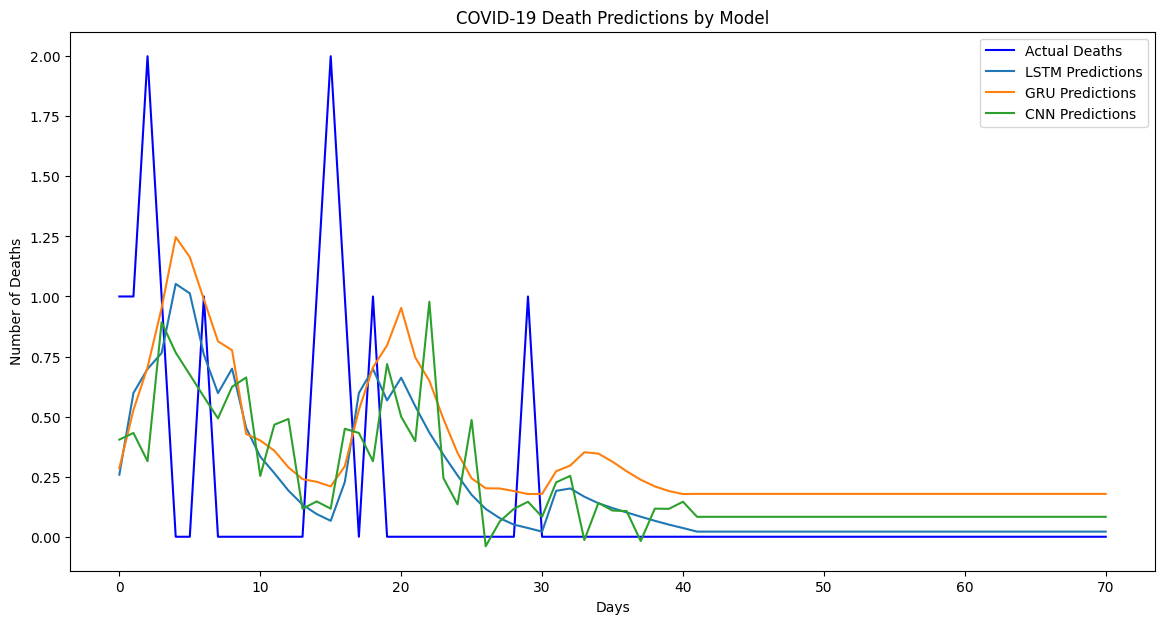

In [ ]:
# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(death[train_size + time_step + 1:], label='Actual Deaths', color='blue')

for model_name, predicted in predictions.items():
    plt.plot(predicted, label=f'{model_name} Predictions')

plt.title('COVID-19 Death Predictions by Model')
plt.xlabel('Days')
plt.ylabel('Number of Deaths')
plt.legend()
plt

In [35]:
# Focusing on discharged cases
discharged = df['Discharged'].values.reshape(-1, 1)


In [36]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
discharged_scaled = scaler.fit_transform(discharged)


In [37]:
# Function to create dataset
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)


In [38]:
# Preparing the data
time_step = 10  # For example, using the past 10 days
X, y = create_dataset(discharged_scaled, time_step)


In [39]:
# Reshape for LSTM and GRU
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [40]:
# Define a function to build and train the models
def build_and_train_model(model_type='LSTM'):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(GRU(units=50, return_sequences=False))
    elif model_type == 'CNN':
        model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
        model.add(Flatten())
        model.add(Dense(units=10, activation='relu'))
    elif model_type == 'TCN':
        # Placeholder for TCN implementation
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
        model.add(Flatten())

    model.add(Dense(units=1))  # Output layer

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    return model

In [41]:
# Train models
models = {
    'LSTM': build_and_train_model('LSTM'),
    'GRU': build_and_train_model('GRU'),
    'CNN': build_and_train_model('CNN'),
    # TCN could be integrated with a library like 'tcn' or custom implementation
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
# Evaluation and Predictions
predictions = {}
for model_name, model in models.items():
    predicted = model.predict(X_test)
    predicted_inversed = scaler.inverse_transform(predicted)
    predictions[model_name] = predicted_inversed

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


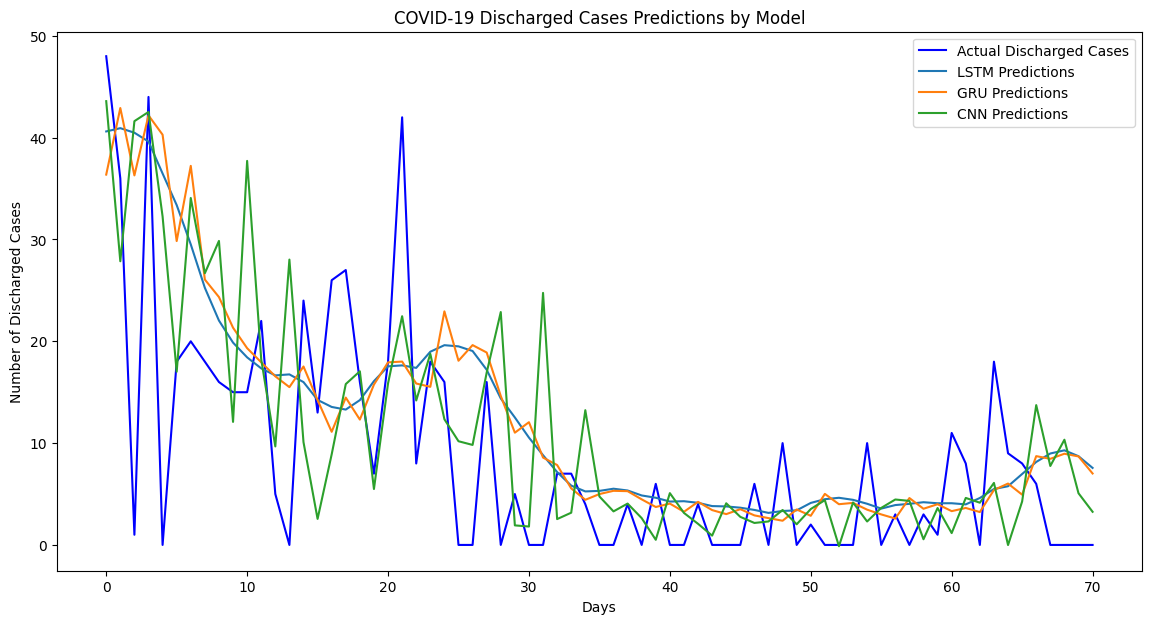

In [43]:
# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(discharged[train_size + time_step + 1:], label='Actual Discharged Cases', color='blue')

for model_name, predicted in predictions.items():
    plt.plot(predicted, label=f'{model_name} Predictions')

plt.title('COVID-19 Discharged Cases Predictions by Model')
plt.xlabel('Days')
plt.ylabel('Number of Discharged Cases')
plt.legend()
plt.show()

In [45]:
# Focusing on confirmed cases
confirmed = df['Confirmed'].values.reshape(-1, 1)

In [46]:

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
confirmed_scaled = scaler.fit_transform(confirmed)

In [47]:
# Function to create dataset
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [49]:
# Preparing the data
time_step = 10  # For example, using the past 10 days
X, y = create_dataset(confirmed_scaled, time_step)

In [50]:

# Reshape for LSTM and GRU
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [54]:
#Define a function to build and train the models
def build_and_train_model(model_type='LSTM'):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(GRU(units=50, return_sequences=False))
    elif model_type == 'CNN':
        model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
        model.add(Flatten())
        model.add(Dense(units=10, activation='relu'))

    model.add(Dense(units=1))  # Output layer

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    return model

In [55]:
# Train models
models = {
    'LSTM': build_and_train_model('LSTM'),
    'GRU': build_and_train_model('GRU'),
    'CNN': build_and_train_model('CNN'),
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:

# Evaluation and Predictions
predictions = {}
for model_name, model in models.items():
    predicted = model.predict(X_test)
    predicted_inversed = scaler.inverse_transform(predicted)
    predictions[model_name] = predicted_inversed

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


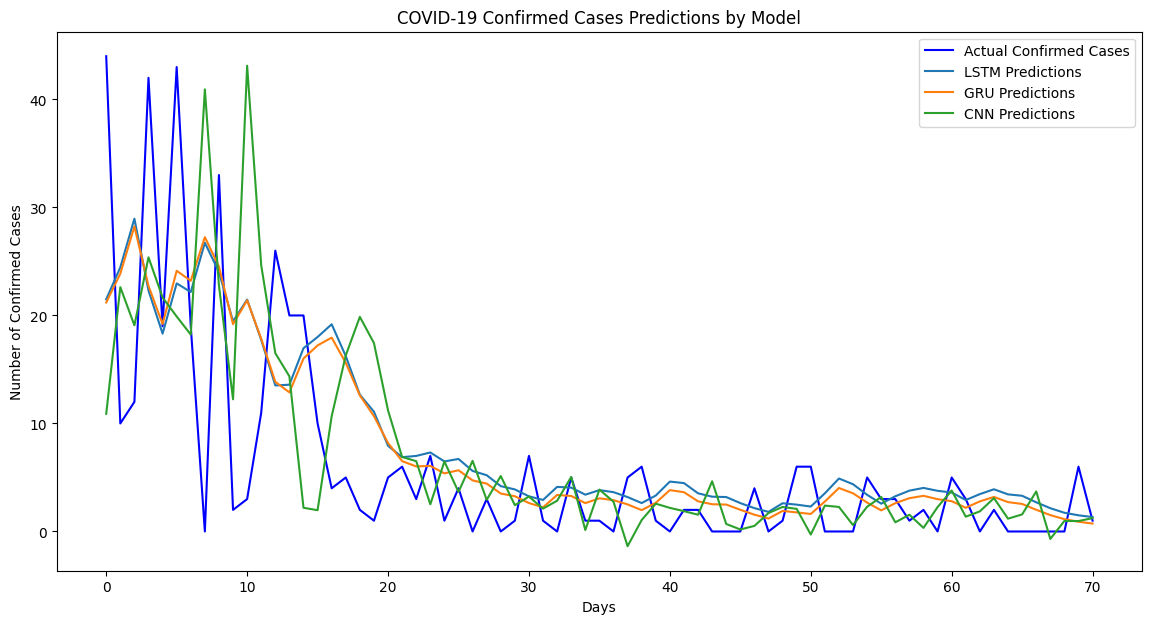

In [57]:
# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(confirmed[train_size + time_step + 1:], label='Actual Confirmed Cases', color='blue')

for model_name, predicted in predictions.items():
    plt.plot(predicted, label=f'{model_name} Predictions')

plt.title('COVID-19 Confirmed Cases Predictions by Model')
plt.xlabel('Days')
plt.ylabel('Number of Confirmed Cases')
plt.legend()
plt.show()

In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, Flatten

In [64]:

# Assume these are the columns of interest
death = df['Death']
discharged = df['Discharged']
confirmed = df['Confirmed']

In [65]:
# Train-Test Split Function
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [67]:

# Create datasets
time_step = 10
X_death, y_death = create_dataset(death.values, time_step)
X_discharged, y_discharged = create_dataset(discharged.values, time_step)
X_confirmed, y_confirmed = create_dataset(confirmed.values, time_step)

In [69]:

# Train-Test Split
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_death, y_death, test_size=0.2, random_state=42)
X_train_di, X_test_di, y_train_di, y_test_di = train_test_split(X_discharged, y_discharged, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_confirmed, y_confirmed, test_size=0.2, random_state=42)

In [70]:
# Function to create LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [71]:
# Train LSTM Model
lstm_model_d = create_lstm_model((X_train_d.shape[1], 1))
lstm_model_d.fit(X_train_d, y_train_d, epochs=50, batch_size=32)
pred_deaths_lstm = lstm_model_d.predict(X_test_d)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.6567
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5231
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6311
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4036
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5838
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4571
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3310
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3235
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4070
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4020
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4522
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4936
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3961
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4265
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4951
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━

In [72]:
# Train GRU Model
X_train_d_gru = X_train_d  # Use reshaped training data
X_test_d_gru = X_test_d  # Use reshaped testing data

def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [73]:
gru_model_d = create_gru_model((X_train_d.shape[1], 1))
gru_model_d.fit(X_train_d_gru, y_train_d, epochs=50, batch_size=32)
pred_deaths_gru = gru_model_d.predict(X_test_d_gru)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4972
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3270
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3618
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3645
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3756
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4804
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3613
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3423
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3146
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3579
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3594
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4485
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5474
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3821
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3878
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━

In [75]:

# Evaluation
mae_d_lstm = mean_absolute_error(y_test_d, pred_deaths_lstm)
rmse_d_lstm = np.sqrt(mean_squared_error(y_test_d, pred_deaths_lstm))

mae_d_gru = mean_absolute_error(y_test_d, pred_deaths_gru)
rmse_d_gru = np.sqrt(mean_squared_error(y_test_d, pred_deaths_gru))

In [76]:
# Print evaluation metrics
print("LSTM Deaths MAE: ", mae_d_lstm)
print("LSTM Deaths RMSE: ", rmse_d_lstm)
print("GRU Deaths MAE: ", mae_d_gru)
print("GRU Deaths RMSE: ", rmse_d_gru)

LSTM Deaths MAE:  0.3335270881652832
LSTM Deaths RMSE:  0.5184120513666831
GRU Deaths MAE:  0.34301888942718506
GRU Deaths RMSE:  0.5151641115254612


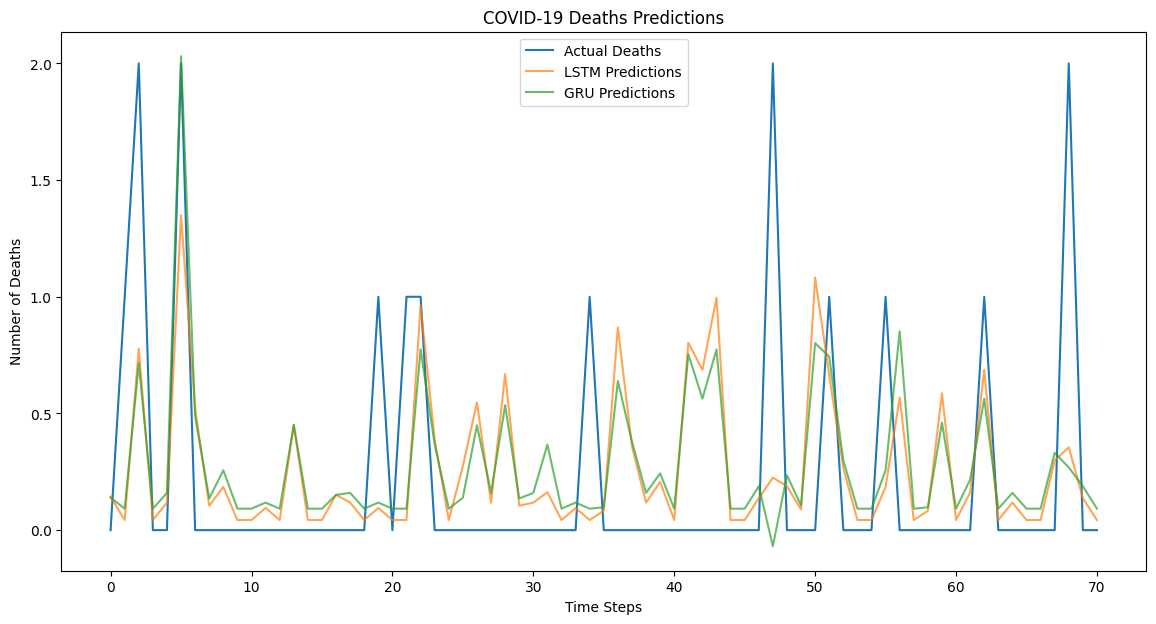

In [77]:
# Visualization of predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_d, label='Actual Deaths')
plt.plot(pred_deaths_lstm, label='LSTM Predictions', alpha=0.7)
plt.plot(pred_deaths_gru, label='GRU Predictions', alpha=0.7)
plt.title('COVID-19 Deaths Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Number of Deaths')
plt.legend()
plt.show()

In [78]:
# CNN Model Creation
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [79]:

# Reshape for CNN
X_train_d_cnn = X_train_d.reshape((X_train_d.shape[0], X_train_d.shape[1], 1))
X_test_d_cnn = X_test_d.reshape((X_test_d.shape[0], X_test_d.shape[1], 1))

In [80]:
# Train CNN Model
cnn_model_d = create_cnn_model((X_train_d.shape[1], 1))
cnn_model_d.fit(X_train_d_cnn, y_train_d, epochs=50, batch_size=32)
pred_deaths_cnn = cnn_model_d.predict(X_test_d_cnn)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6800
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4351 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4769 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3903 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2646 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3114 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3554 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2708 
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2746 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3727 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3152 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2504 
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3783 
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3750 
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3626 
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

In [81]:
# Evaluation for CNN
mae_d_cnn = mean_absolute_error(y_test_d, pred_deaths_cnn)
rmse_d_cnn = np.sqrt(mean_squared_error(y_test_d, pred_deaths_cnn))

In [82]:
# Print CNN metrics
print("CNN Deaths MAE: ", mae_d_cnn)
print("CNN Deaths RMSE: ", rmse_d_cnn)

CNN Deaths MAE:  0.5409191250801086
CNN Deaths RMSE:  1.4520757845550578


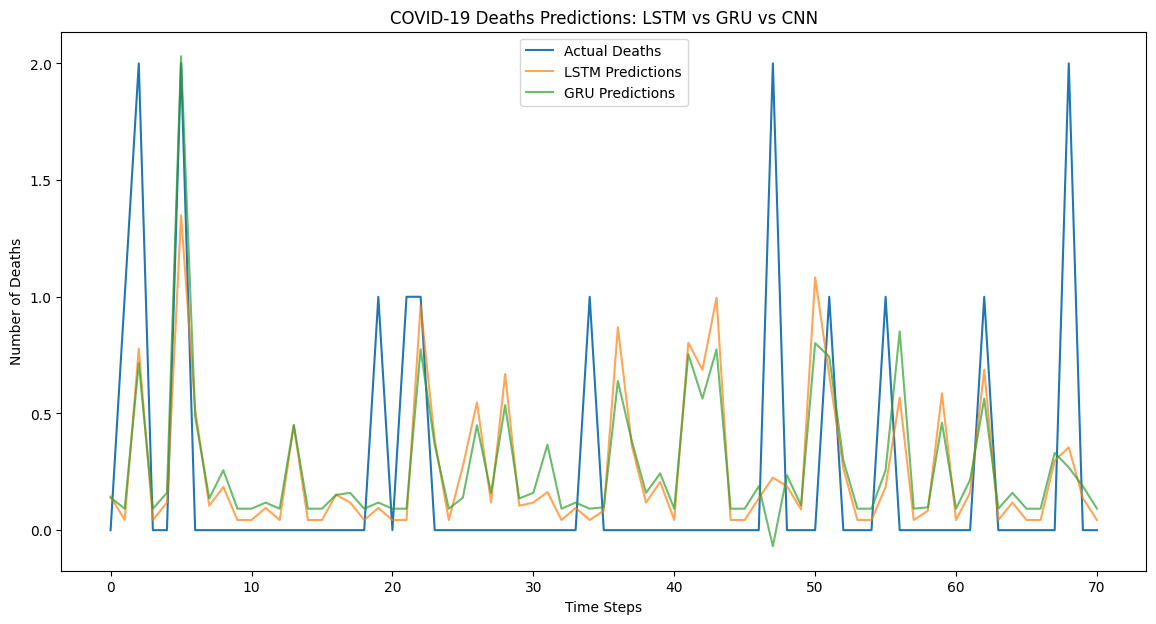

In [91]:
# Plot all models' predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_d, label='Actual Deaths')
plt.plot(pred_deaths_lstm, label='LSTM Predictions', alpha=0.7)
plt.plot(pred_deaths_gru, label='GRU Predictions', alpha=0.7)
#plt.plot(pred_deaths_cnn, label='CNN Predictions', alpha=0.7)
plt.title('COVID-19 Deaths Predictions: LSTM vs GRU vs CNN')
plt.xlabel('Time Steps')
plt.ylabel('Number of Deaths')
plt.legend()
plt.show()